In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from lie.SE23 import *
from flowpipe.inner_bound import *
from flowpipe.outer_bound import *
from bezier.bezier_planning import generate_path, derive_bezier6
from flowpipe.flowpipe import *
from sim.multirotor_control import *

In [2]:
bezier6 = derive_bezier6()
bc_t = np.array(
    [  # boundary conditions
        [
            [0, 0, 0],
            [1, 0, 0],
            [1, 1, 1],
            [2, 1, 1],
            [2, 2, 1],
            [1, 2, 0],
            [0, 2, 0],
            [-1, 2, 0],
            [-2,2,0],
            [-2,1,0],
            [-2,0,0]
        ],  # pos
        [
            [0, 0, 0],
            [0.3, 0, 0],
            [0, 0.3, 0.3],
            [0.3, 0, 0],
            [0, 0.3, 0],
            [-0.3, 0, 0],
            [-0.3, 0, -0.3],
            [-0.3, 0, 0],
            [-0.3, 0, 0],
            [0, -0.3, 0],
            [0, 0, 0]
        ],  # vel
    ]
)
# solve for bezier trajectories
k = 10
ref = generate_path(bc_t, k)
x = ref['traj_x']
y = ref['traj_y']
z = ref['traj_z']
t = ref['T']
Px = ref['anchor_x']
Py = ref['anchor_y']
Pz = ref['anchor_z']

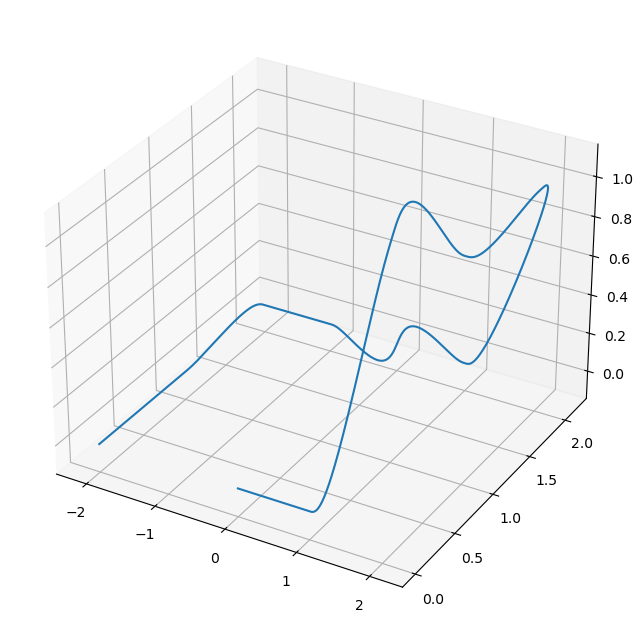

In [3]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z)

In [4]:
ax = [np.min(ref['acc_x']), np.max(ref['acc_x'])]
ay = [np.min(ref['acc_y']), np.max(ref['acc_y'])]
az = [np.min(ref['acc_z'])-9.8, np.max(ref['acc_z'])-9.8]
omega1 = [np.min(ref['omega_1']), np.max(ref['omega_1'])]
omega2 = [np.min(ref['omega_2']), np.max(ref['omega_2'])]
omega3 = [np.min(ref['omega_3']), np.max(ref['omega_3'])]

In [5]:
# Set disturbance here
w1 = 0.1 # disturbance for translational
w2 = 0.01 # disturbance for angular

In [6]:
# solve LMI
sol = find_omega_invariant_set(omega1, omega2, omega3) 

# Initial condition
P = sol['P']
e0 = np.array([0,0,0]) # initial error
beta = (e0.T@P@e0) # initial Lyapnov value

# find bound
omegabound = omega_bound(omega1, omega2, omega3, w2, beta) # result for inner bound
print(omegabound)

0.0031622776667957486


In [7]:
# solve LMI
sol_LMI = find_se23_invariant_set(ax, ay, az, omega1, omega2, omega3)

0.4
optimal


In [57]:
# Initial condition
e = np.array([0,0,0,0,0,0,0,0,0]) # initial error in Lie group (nonlinear)

# transfer initial error to Lie algebra (linear)
e0 = ca.DM(SE23Dcm.vee(SE23Dcm.log(SE23Dcm.matrix(e))))
e0 = np.array([e0]).reshape(9,)
ebeta = e0.T@sol_LMI['P']@e0

# find invairant set points in Lie algebra (linear)
points, val = se23_invariant_set_points(sol_LMI, 20, w1, omegabound, ebeta)
points_theta, val = se23_invariant_set_points_theta(sol_LMI, 20, w1, omegabound, ebeta)

In [58]:
# map invariant set points to Lie group (nonlinear)
inv_points = exp_map(points, points_theta)

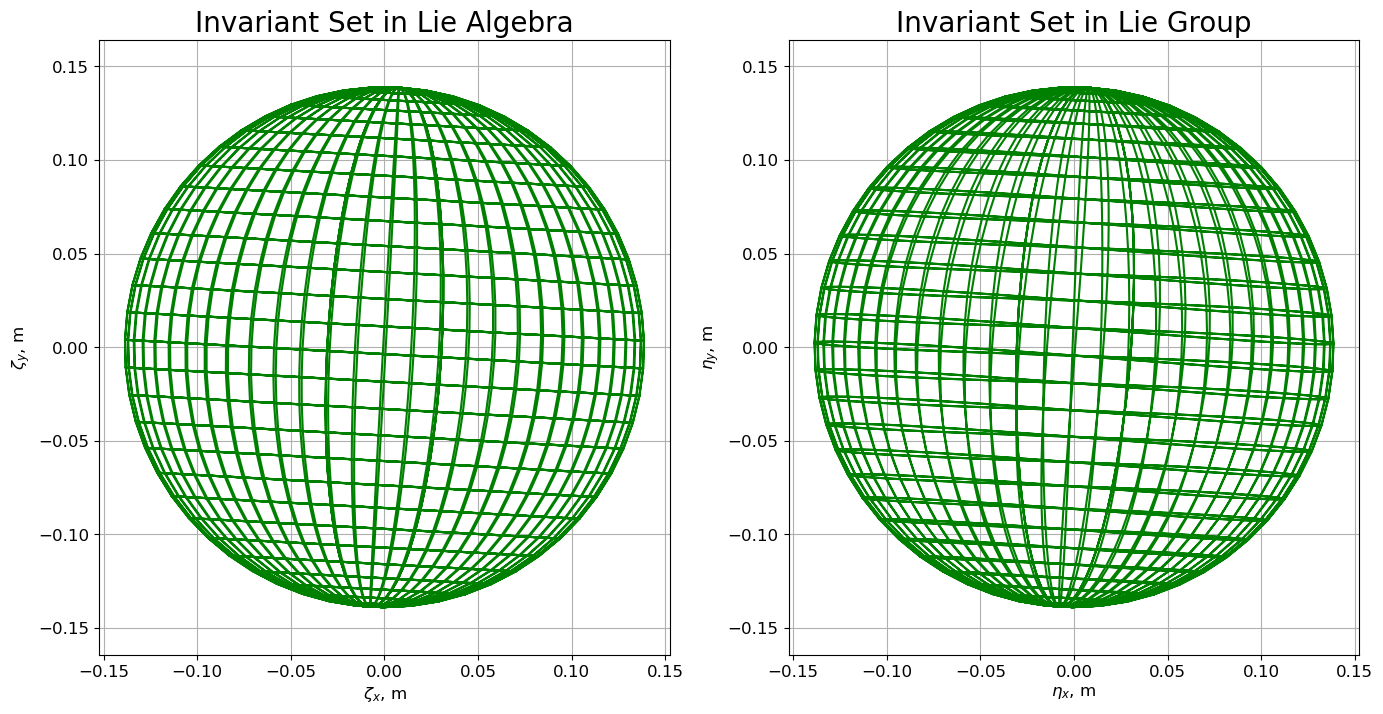

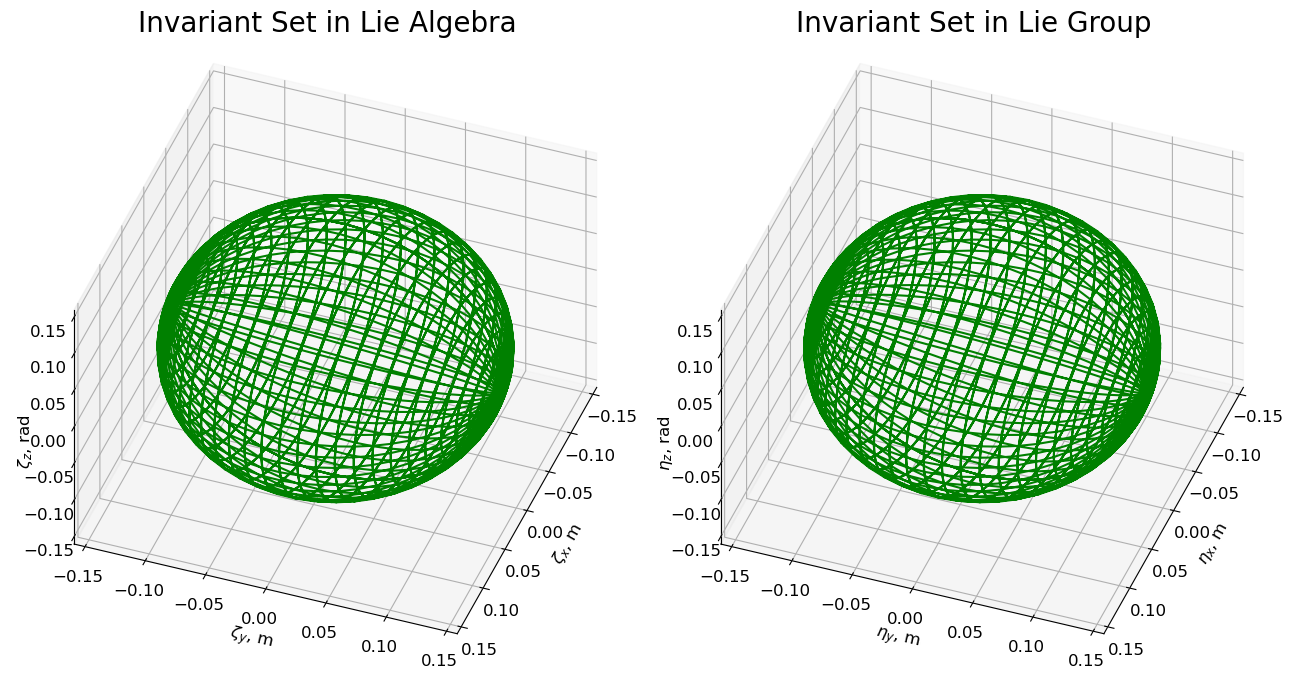

In [59]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 12})
ax1 = plt.subplot(121)
ax1.plot(points[0, :], points[1, :], 'g', label='with Dynamic Inversion')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_x$, m')
ax1.set_ylabel('$\\zeta_y$, m')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
# plt.legend(loc=1)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g', label='with Dynamic Inversion')
# ax2.plot(inv_pointscl[0, :-1], inv_pointscl[1, :-1], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
plt.grid(True)
# plt.legend(loc=1)
plt.axis('equal')
plt.tight_layout()
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
# plt.savefig('figures/Invariant_l.eps', format='eps', bbox_inches='tight')

plt.figure(figsize=(14,7))
ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax1.plot3D(points[0, :], points[1, :], points[2, :],'g', label='with Dynamic Inversion')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_x$, m')
ax1.set_ylabel('$\\zeta_y$, m')
ax1.set_zlabel('$\\zeta_z$, rad', labelpad=1)
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
# plt.subplots_adjust(left=9, right=10, top=0.5, bottom=0.08)
# plt.tight_layout()
plt.axis('auto')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.legend(loc=1)
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g', label='with Dynamic Inversion')
# ax2.plot3D(inv_pointscl[0, :], inv_pointscl[1, :], inv_pointscl[2, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
ax2.set_zlabel('$\\eta_z$, rad')
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
plt.axis('auto')
plt.subplots_adjust(left=0.45, right=1, top=0.5, bottom=0.08)
# plt.legend(loc=1)
plt.tight_layout()
# plt.savefig('figures/Invariant3d_l.eps', format='eps', bbox_inches='tight')

In [29]:
from flowpipe.flowpipe import *

In [60]:
# Calculate convex hull for flow pipes
n = 30 # number of flow pipes
flowpipes_traj, intervalhull_traj, nom_traj, t_vect = flowpipes(ref, n, ebeta, w1, omegabound, sol_LMI)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


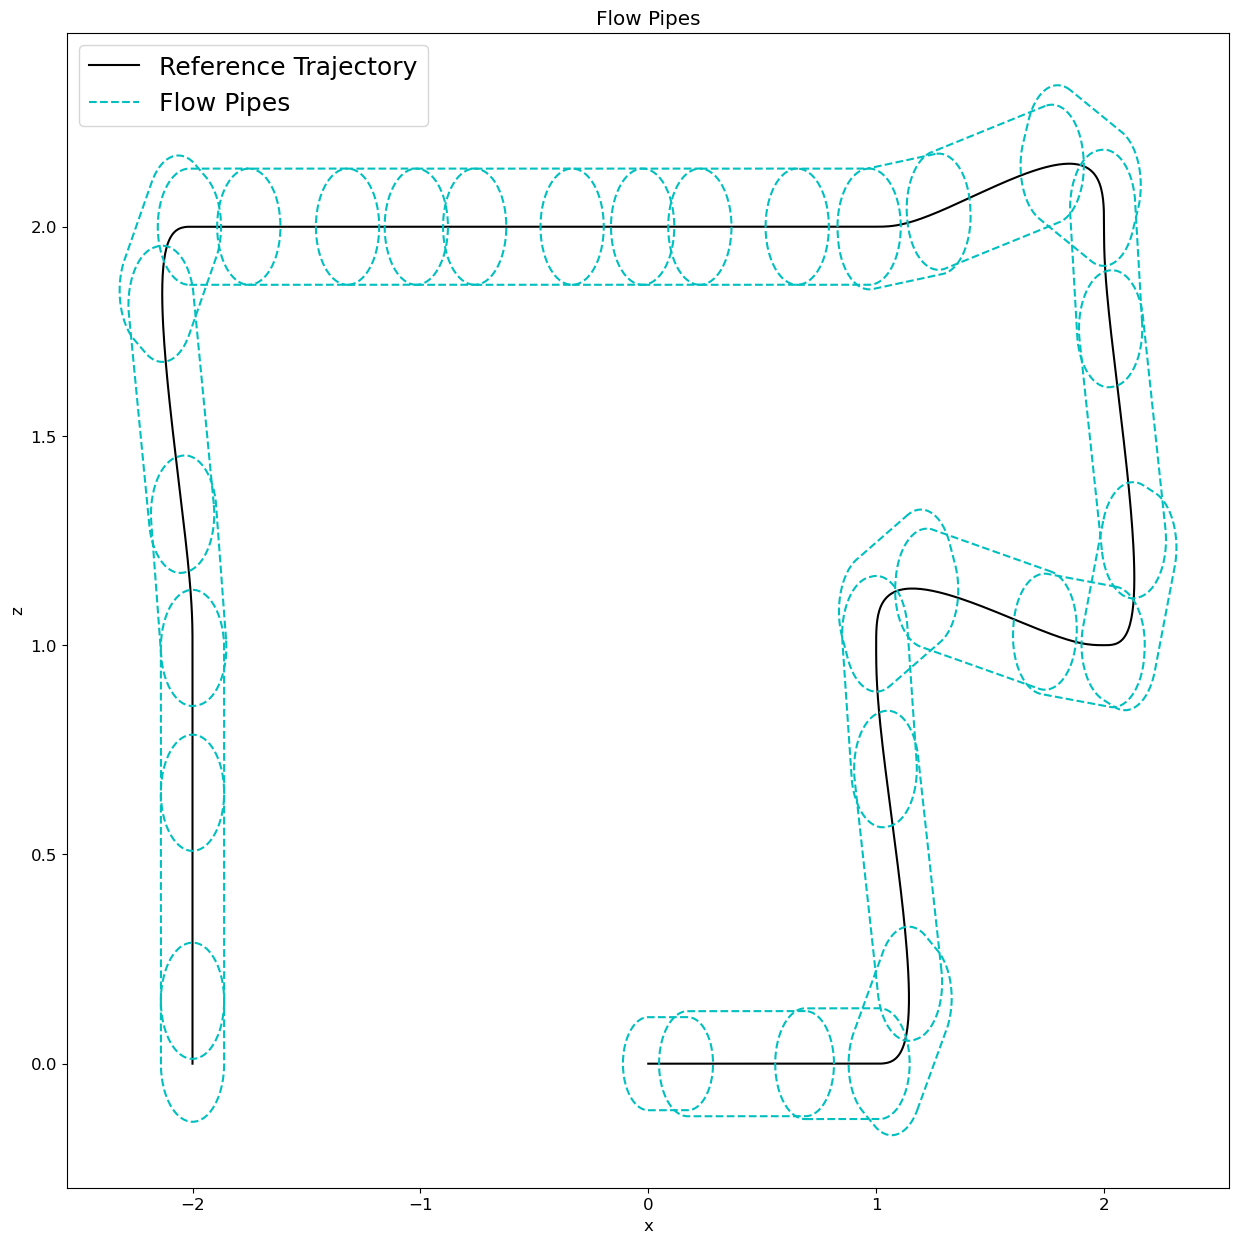

In [61]:
plot_flowpipes(nom_traj, flowpipes_traj, n)

max frequencies [0.00015915494309189535, 0.00015915494309189535, 0.15374645704757883]


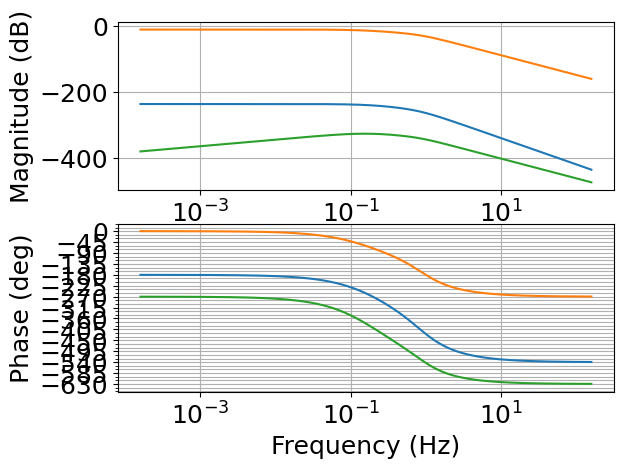

In [47]:
def bode_analysis():
    B, K, _, _ = se23_solve_control(1e-10, 0, 9.8, 0, 0, 0)
    A = -ca.DM(SE23Dcm.ad_matrix(np.array([0,0,0,0,0,9.8,0,0,0]))+SE23Dcm.adC_matrix())
    B = np.array([[0,0,0,0], # vx
                  [0,0,0,0], # vy
                  [0,0,0,0], # vz
                  [0,0,0,0], # ax
                  [0,0,0,0], # ay
                  [1,0,0,0], # az
                  [0,1,0,0], # omega1
                  [0,0,1,0], # omega2
                  [0,0,0,1]]) # omega3 # control omega1,2,3, and az
    s1 = control.ss(A, B, np.eye(9), np.zeros((9, 4)))
    s2 = s1.feedback(-K)
    G = control.ss2tf(s2)
    mag, phase, omega = control.bode(
        [G[0, 0], G[1, 1], G[2, 1]],
        omega=np.logspace(-3, 3, 1000), 
        Hz=True, dB=True);
    max_frequencies = [ omega[i][np.argmax(mag[i])]/(2*np.pi) for i in range(len(mag)) ]
    print('max frequencies', max_frequencies)

bode_analysis()

5
5.5
6
6.5
7
7.5
8


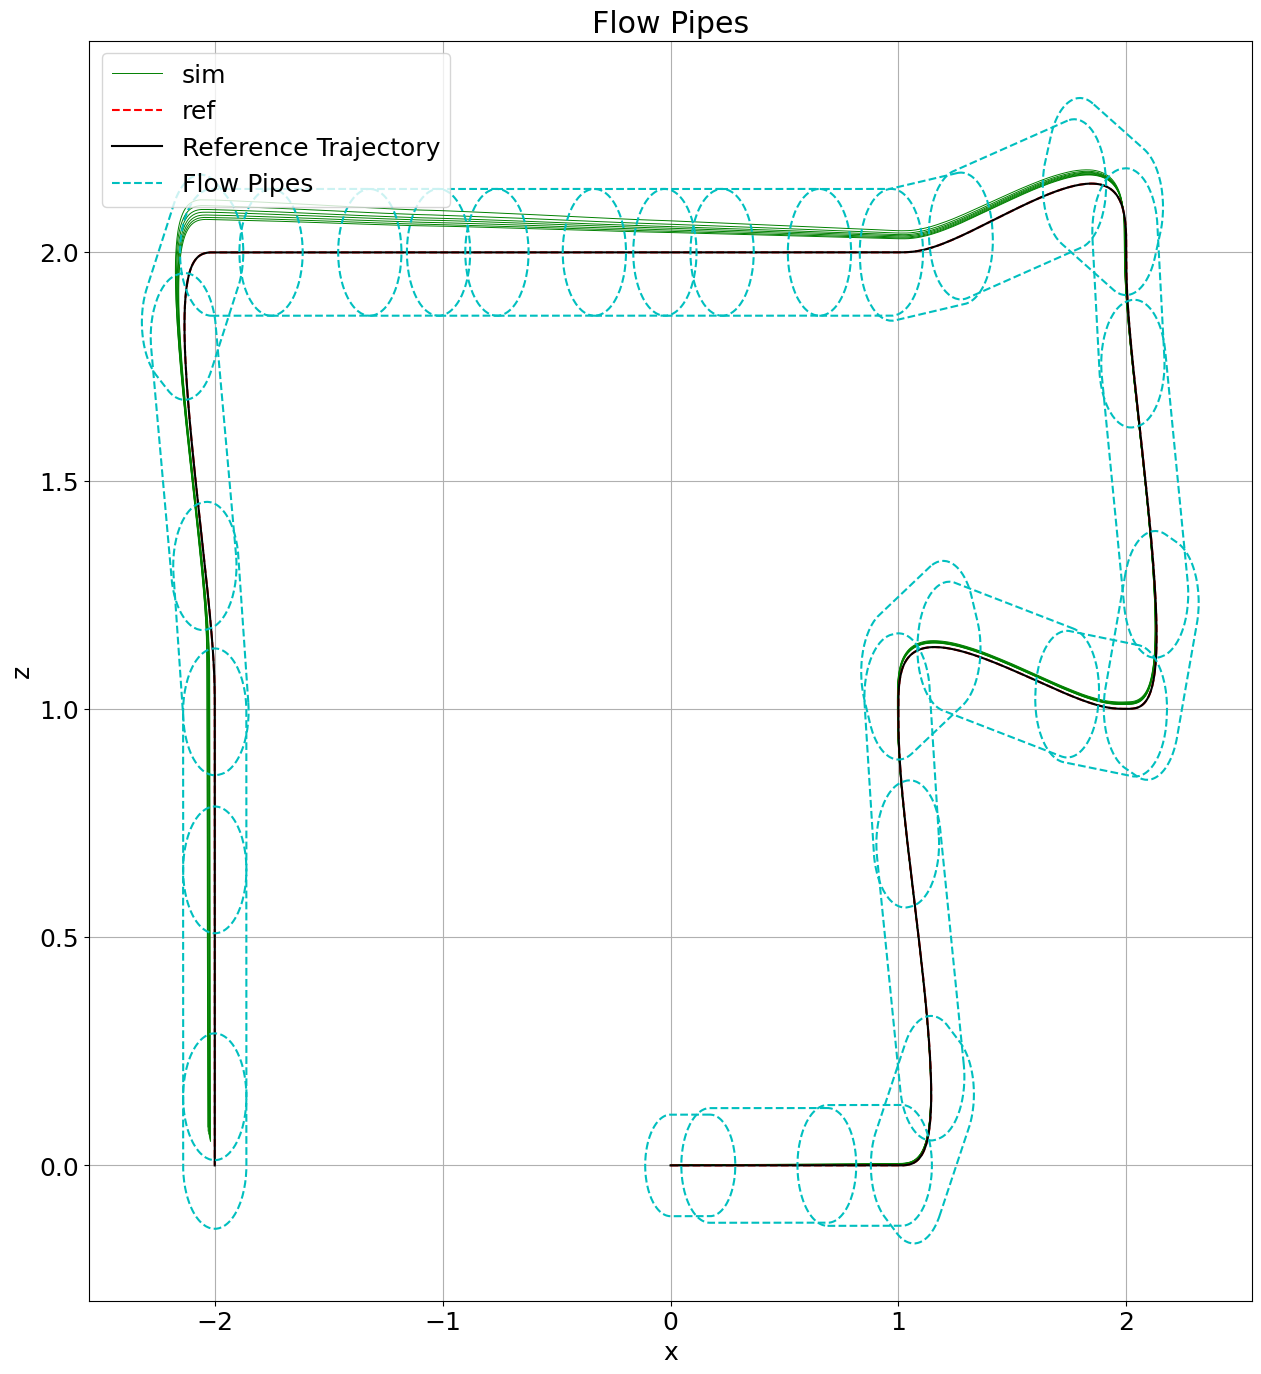

In [62]:
f = [5,5.5,6,6.5,7,7.5,8]
plot_sim(f, ref, w1, omegabound, nom_traj, flowpipes_traj, n)

In [72]:
# calculte bound along time (small disturbance case)
n_time = 50
T0_list = ref['T0']
T = np.cumsum(T0_list)
t_vect = np.linspace(1e-5,np.cumsum(T0_list)[-1],n_time)
bound_s = np.zeros((6,n_time))
for i in range(0,n_time):
    for k in range(T.shape[0]):
        if k==0 and t_vect[i] <= T[k]:
            traj_x = np.array(bezier6['bezier6_traj'](t_vect[i], ref['T0'][k], Px[k])).T
            traj_y = np.array(bezier6['bezier6_traj'](t_vect[i], ref['T0'][k], Py[k])).T
            traj_z = np.array(bezier6['bezier6_traj'](t_vect[i], ref['T0'][k], Pz[k])).T
        elif k > 0 and T[k-1] < t_vect[i] <= T[k]:
            traj_x = np.array(bezier6['bezier6_traj'](t_vect[i]-T[k-1], ref['T0'][k], Px[k])).T
            traj_y = np.array(bezier6['bezier6_traj'](t_vect[i]-T[k-1], ref['T0'][k], Py[k])).T
            traj_z = np.array(bezier6['bezier6_traj'](t_vect[i]-T[k-1], ref['T0'][k], Pz[k])).T
    rx = traj_x[:,0][0]
    ry = traj_y[:,0][0]
    rz = traj_z[:,0][0]
    ib = inv_bound(sol_LMI, t_vect[i], w1, omegabound, ebeta)
    ib[0] = rx + ib[0]
    ib[1] = ry + ib[1]
    ib[2] = rz + ib[2]
    ib[3] = rx + ib[3]
    ib[4] = ry + ib[4]
    ib[5] = rz + ib[5]
    bound_s[:,i] = ib

0.65
0.7
0.8
0.9
1


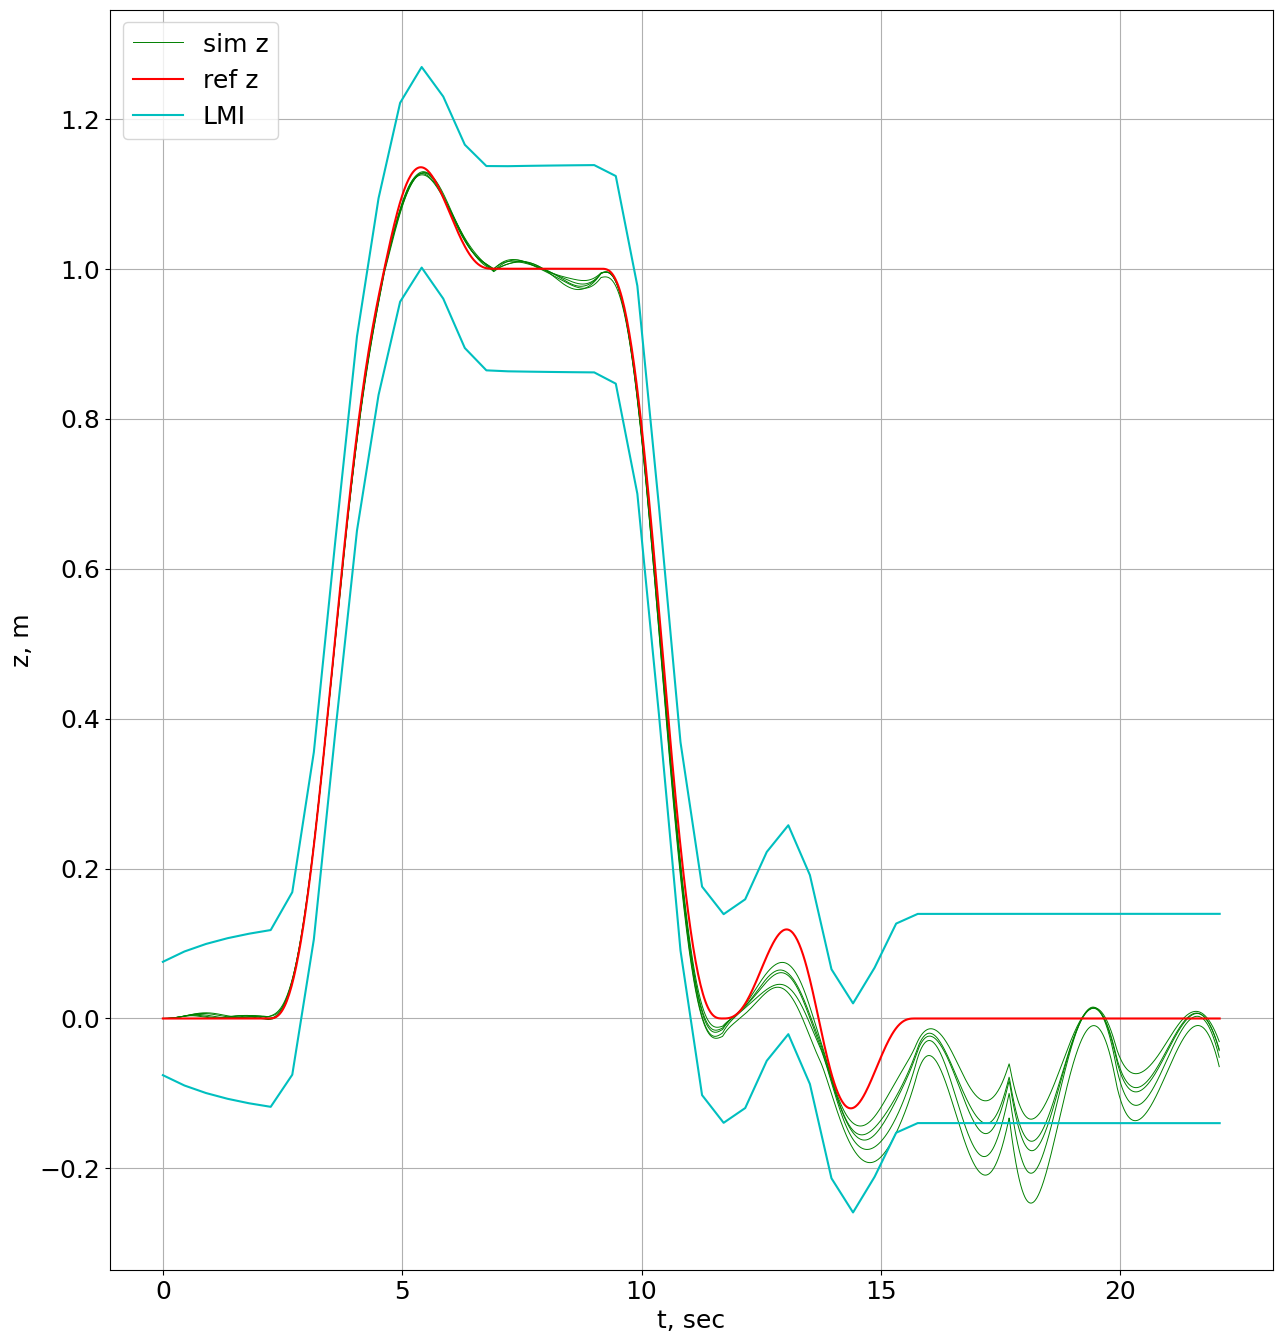

In [73]:
f = [0.65,0.7,0.8,0.9,1]
plot_timehis(f, ref, w1, w2, bound_s, n_time)